# Time Series Forecast with 1D CNN

* We can combine the speed and lightness of convnets with the order-sensitivity of RNNs is to use a 1D convnet as a preprocessing step before a RNN. 
  * This is especially beneficial when dealing with sequences that are so long that they couldn't realistically be processed with RNNs, e.g. sequences with thousands of steps. The convnet will turn the long input sequence into much shorter (downsampled) sequences of higher-level features. This sequence of extracted features then becomes the input to the RNN part of the network.
* 1D CNN means the kernel slides only need to move along 1 dimension
  * 2D means wdidth and height
  * 3D means wdidth, height and depth

In [1]:
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('data/pm25.csv')

print(df.shape)
df.head()

(43824, 13)


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [3]:
df.dropna(subset=['pm2.5'], axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

df['datetime'] = df[['year', 'month', 'day', 'hour']].apply(
    lambda row: datetime.datetime(year=row['year'], 
                                  month=row['month'], day=row['day'],hour=row['hour']), axis=1)
df.sort_values('datetime', ascending=True, inplace=True)

scaler = MinMaxScaler(feature_range=(0, 1))
df['scaled_pm2.5'] = scaler.fit_transform(np.array(df['pm2.5']).reshape(-1, 1))

split_date = datetime.datetime(year=2014, month=1, day=1, hour=0)  
df_train = df.loc[df['datetime']<split_date]
df_val = df.loc[df['datetime']>=split_date]
df_val.reset_index(drop=True, inplace=True)
print('Shape of train:', df_train.shape)
print('Shape of test:', df_val.shape)

Shape of train: (33096, 15)
Shape of test: (8661, 15)


In [4]:
def makeXy(ts, nb_timesteps):
    """
    Input: 
           ts: original time series
           nb_timesteps: number of time steps in the regressors
    Output: 
           X: 2-D array of regressors
           y: 1-D array of target 
    """
    X = []
    y = []
    for i in range(nb_timesteps, ts.shape[0]):
        X.append(list(ts.loc[i-nb_timesteps:i-1]))
        y.append(ts.loc[i])
        
    X, y = np.array(X), np.array(y)
    return X, y

In [5]:
X_train, y_train = makeXy(df_train['scaled_pm2.5'], 7)
X_val, y_val = makeXy(df_val['scaled_pm2.5'], 7)

print('Shape of train arrays:', X_train.shape, y_train.shape)
print('Shape of validation arrays:', X_val.shape, y_val.shape)

Shape of train arrays: (33089, 7) (33089,)
Shape of validation arrays: (8654, 7) (8654,)


In [6]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
print('Shape of arrays after reshaping:', X_train.shape, X_val.shape)

Shape of arrays after reshaping: (33089, 7, 1) (8654, 7, 1)


In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Conv1D
from tensorflow.keras.layers import Dense, Dropout, Input, ZeroPadding1D, AveragePooling1D, Flatten
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import mean_absolute_error

tf.random.set_seed(10)

### 1D CNN Only

* ZeroPadding1D layer is added next to add zeros at the begining and end of each series. 
  * Zeropadding ensure that the downstream convolution layer does not reduce the dimension of the output sequences.
  * Pooling layer, added after the convolution layer is used to downsampling the input.
* In Con1D
  * param 1 determines the number of features in the output
  * param 2 indicates length of the 1D convolution window, moving window size
  * param 3 is strides of the moving window, representing the number of places to shift the convolution window
  * `use_bias` as True, adds a bias value during computation of an output feature
  * 1D convolution can be thought of as generating local AR models over rolling window of three time units.
* AveragePooling1D is added next to downsample the input by taking average over pool size of three with stride of one timesteps. 
  * The average pooling in this case can be thought of as taking moving averages over a rolling window of three time units.
* The Flatten layer reshapes the input to `(number of samples, number of timesteps*number of features per timestep)`, which is then fed to the output layer

In [32]:
model = Sequential()
model.add(ZeroPadding1D(padding=1,
               input_shape=(X_train.shape[1:])))
model.add(Conv1D(64, 3, strides=1, use_bias=True))
model.add(Conv1D(32, 3, strides=1, use_bias=True))
model.add(AveragePooling1D(pool_size=3, strides=1))
model.add(Flatten())
model.add(Dense(32))
model.add(Dense(16))
model.add(Dropout(0.2))
model.add(Dense(1, activation='tanh'))

model.compile(optimizer=Adam(amsgrad=True), loss='mean_absolute_error', metrics='mae')
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding1d_7 (ZeroPaddin (None, 9, 1)              0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 7, 64)             256       
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 5, 32)             6176      
_________________________________________________________________
average_pooling1d_7 (Average (None, 3, 32)             0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 96)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                3104      
_________________________________________________________________
dense_13 (Dense)             (None, 16)              

In [39]:
save_weights_at = '1dcnn_model'
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            save_freq='epoch')
history = model.fit(x=X_train, y=y_train, batch_size=20, epochs=50,
             verbose=1, callbacks=[save_best], validation_data=(X_val, y_val),
             shuffle=True)

Epoch 1/50
1655/1655 [==============================] - 16s 9ms/step - loss: 0.0144 - mae: 0.0144 - val_loss: 0.0129 - val_mae: 0.0129
INFO:tensorflow:Assets written to: 1dcnn_model\assets
Epoch 2/50
1655/1655 [==============================] - 16s 10ms/step - loss: 0.0144 - mae: 0.0144 - val_loss: 0.0126 - val_mae: 0.0126
INFO:tensorflow:Assets written to: 1dcnn_model\assets
Epoch 3/50
1655/1655 [==============================] - 19s 11ms/step - loss: 0.0144 - mae: 0.0144 - val_loss: 0.0124 - val_mae: 0.0124ss: 0.0145 - m - ETA: 0s - loss: 0.0145 - mae: 
INFO:tensorflow:Assets written to: 1dcnn_model\assets
Epoch 4/50
1655/1655 [==============================] - 22s 13ms/step - loss: 0.0144 - mae: 0.0144 - val_loss: 0.0127 - val_mae: 0.0127
Epoch 5/50
1655/1655 [==============================] - 20s 12ms/step - loss: 0.0144 - mae: 0.0144 - val_loss: 0.0125 - val_mae: 0.0125
Epoch 6/50
1655/1655 [==============================] - 19s 11ms/step - loss: 0.0144 - mae: 0.0144 - val_loss: 0

MAE for the validation set: 12.2419
MAE for the scaled validation set: 0.0123


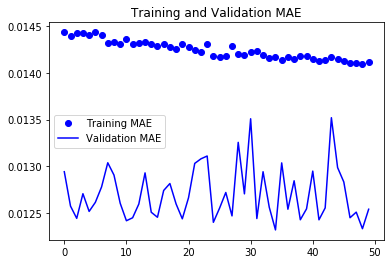

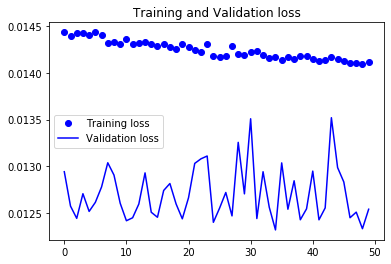

In [40]:
# load the best model
best_model = load_model('1dcnn_model')

# Compare the prediction with y_true
preds = best_model.predict(X_val)
pred_pm25 = scaler.inverse_transform(preds)
pred_pm25 = np.squeeze(pred_pm25)

# Measure MAE of y_pred and y_true
mae = mean_absolute_error(df_val['pm2.5'].loc[7:], pred_pm25)
print('MAE for the validation set:', round(mae, 4))

mae = mean_absolute_error(df_val['scaled_pm2.5'].loc[7:], preds)
print('MAE for the scaled validation set:', round(mae, 4))

# Check the metrics and loss of each apoch
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(mae))

plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.legend()

plt.figure()

# Here I was using MAE as loss too, that's why they lookedalmost the same...
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

### Add LSTM after 1D CNN

In [36]:
model = Sequential()
model.add(ZeroPadding1D(padding=1,
               input_shape=(X_train.shape[1:])))
model.add(Conv1D(64, 3, strides=1, use_bias=True))
model.add(Conv1D(32, 3, strides=1, use_bias=True))
model.add(AveragePooling1D(pool_size=3, strides=1))
model.add(LSTM(32, dropout=0.1, recurrent_dropout=0.5, activation='tanh'))
model.add(Dense(1, activation='tanh'))

model.compile(optimizer=Adam(amsgrad=True), loss='mean_absolute_error', metrics='mae')
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding1d_9 (ZeroPaddin (None, 9, 1)              0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 7, 64)             256       
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 5, 32)             6176      
_________________________________________________________________
average_pooling1d_9 (Average (None, 3, 32)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 14,785
Trainable params: 14,785
Non-trainable params: 0
_________________________________________________

In [37]:
save_weights_at = '1dcnn_lstm_model'
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            save_freq='epoch')
history = model.fit(x=X_train, y=y_train, batch_size=16, epochs=20,
             verbose=1, callbacks=[save_best], validation_data=(X_val, y_val),
             shuffle=True)

Epoch 1/20
2069/2069 [==============================] - 24s 9ms/step - loss: 0.0218 - mae: 0.0218 - val_loss: 0.0140 - val_mae: 0.0140
INFO:tensorflow:Assets written to: 1dcnn_lstm_model\assets
Epoch 2/20
2069/2069 [==============================] - 18s 9ms/step - loss: 0.0164 - mae: 0.0164 - val_loss: 0.0141 - val_mae: 0.0141
Epoch 3/20
2069/2069 [==============================] - 26s 13ms/step - loss: 0.0158 - mae: 0.0158 - val_loss: 0.0133 - val_mae: 0.0133 0.0158 
INFO:tensorflow:Assets written to: 1dcnn_lstm_model\assets
Epoch 4/20
2069/2069 [==============================] - 29s 14ms/step - loss: 0.0155 - mae: 0.0155 - val_loss: 0.0145 - val_mae: 0.0145
Epoch 5/20
2069/2069 [==============================] - 28s 14ms/step - loss: 0.0151 - mae: 0.0151 - val_loss: 0.0143 - val_mae: 0.0143
Epoch 6/20
2069/2069 [==============================] - 28s 13ms/step - loss: 0.0155 - mae: 0.0155 - val_loss: 0.0140 - val_mae: 0.0140
Epoch 7/20
2069/2069 [==============================] - 29s 

MAE for the validation set: 12.4811
MAE for the scaled validation set: 0.0126


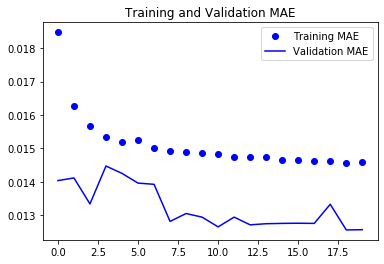

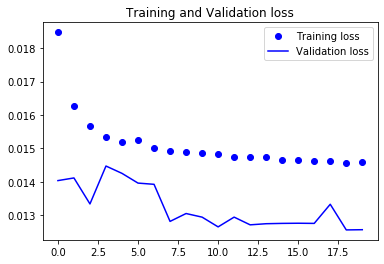

In [38]:
# load the best model
best_model = load_model('1dcnn_lstm_model')

# Compare the prediction with y_true
preds = best_model.predict(X_val)
pred_pm25 = scaler.inverse_transform(preds)
pred_pm25 = np.squeeze(pred_pm25)

# Measure MAE of y_pred and y_true
mae = mean_absolute_error(df_val['pm2.5'].loc[7:], pred_pm25)
print('MAE for the validation set:', round(mae, 4))

mae = mean_absolute_error(df_val['scaled_pm2.5'].loc[7:], preds)
print('MAE for the scaled validation set:', round(mae, 4))

# Check the metrics and loss of each apoch
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(mae))

plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.legend()

plt.figure()

# Here I was using MAE as loss too, that's why they lookedalmost the same...
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

## Note

* 1D CNN only is faster when there is same amount of epoches and batch_size
  * In this case, both experiments got same performance whe epoch and batch_size were the same
* Both experiments appear to be a little bit underfitting